In [ ]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import multi_dot
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import dstep

# Linearizing the system
# Defining systame parameters
a1 = 2.3 # cm^2
a2 = 2.3 # cm^2
a3 = 2.3 # cm^2
a4 = 2.3 # cm^2
A1 = 730 # cm^2
A2 = 730 # cm^2
A3 = 730 # cm^2
A4 = 730 # cm^2
h1_0 = 14.1839 # cm
h2_0 = 11.25046 # cm
h3_0 = 21.0841 # cm
h4_0 = 31.0452 # cm
k1 = 2.51 # cm^3/s
k2 = 5.58 # cm^3/s
g = 981 # cm/s^2
gamma1 = 0.54
gamma2 = 0.45
v1 = 70
v2 = 3.5
qa = v1*k1 # cm^3/s
qb = v2*k2 # cm^3/s
qb

19.53

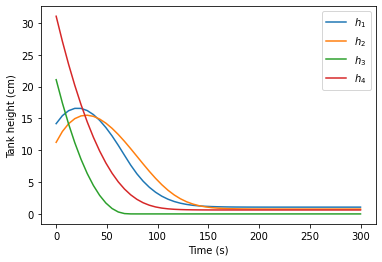

1.074819127519215 0.7736855001195545 0.011116682202875443 0.6293677988323575


In [ ]:
def f(t, hj):
  h1,h2,h3,h4 = hj
  dh1dt = -a1 / A1 * (2 * g * h1) ** 0.5 + a3 / A1 * (2 * g * h3) ** 0.5 + gamma1 * qa / A1
  dh2dt = -a2 / A2 * (2 * g * h2) ** 0.5 + a4 / A2 * (2 * g * h4) ** 0.5 + gamma2 * qb / A2
  dh3dt = -a3 / A3 * (2 * g * h3) ** 0.5 + (1 - gamma2) * qb / A3
  dh4dt = -a4 / A4 * (2 * g * h4) ** 0.5 + (1 - gamma1) * qa / A4
  return [dh1dt,dh2dt,dh3dt,dh4dt]

hj0 = np.array([h1_0,h2_0,h3_0,h4_0]) 
sol = solve_ivp(fun=f, t_span=(0, 300), y0=hj0, max_step=0.1, t_eval=np.linspace(0,300))

plt.plot(sol.t, sol.y[0], label='$h_{1}$')
plt.plot(sol.t, sol.y[1], label='$h_{2}$')
plt.plot(sol.t, sol.y[2], label='$h_{3}$')
plt.plot(sol.t, sol.y[3], label='$h_{4}$')
plt.xlabel('Time (s)')
plt.ylabel('Tank height (cm)')
plt.legend()
plt.show();
print(sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1])

In [ ]:
T1 = A1 / a1 * np.sqrt(2 * h1_0 / g)
T2 = A2 / a2 * np.sqrt(2 * h2_0 / g)
T3 = A3 / a3 * np.sqrt(2 * h3_0 / g)
T4 = A4 / a4 * np.sqrt(2 * h4_0 / g)

A = np.array([[-1 / T1, 0, A3 / (A1 * T3), 0],
              [0, -1 / T2, 0,A4 / (A2 * T4)],
              [0, 0, -1 / T3, 0],
              [0, 0, 0, -1 / T4]])
#B = np.array([[gamma1 * k1 / A1, 0],[0, gamma2 * k2 / A3],[0, (1-gamma2) * k2 / A3],[(1-gamma1) * k1 / A4, 0]])
B = np.array([[gamma1 / A1, 0],[0, gamma2 / A3],[0, (1-gamma2) / A3],[(1-gamma1) / A4, 0]])
C = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
D = np.array([[0, 0],[0, 0]])

In [ ]:
# Model Predictive Control
P = 6 # prediction horizon
M = 5
w = 1 # weight
W = w * np.eye(2*M) # weight matrix for 1 input
print(W.shape)
r1 = np.ones((P,1)) * 18 # single output set point
r2 = np.ones((P,1)) * 15 # single output set point

N = 5000 # model length, duration of time
delta_t = 0.1 # sample time
tf_step = N * delta_t #final simulation time for step response generation in s
t_step = np.linspace(0, tf_step, N+1)

t_f = 10000 # total simulation time in s, not necessarily step response generation
t = np.linspace (0, t_f, round(t_f/delta_t)+1)

(10, 10)


array([[7.39041171e-05, 5.71832197e-08],
       [3.94139359e-08, 6.15797592e-05],
       [0.00000000e+00, 7.52852472e-05],
       [6.29742574e-05, 0.00000000e+00]])

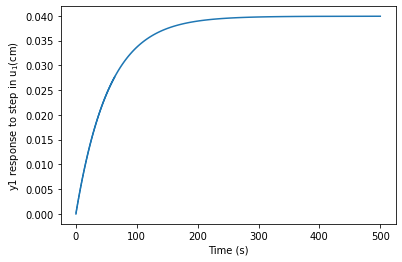

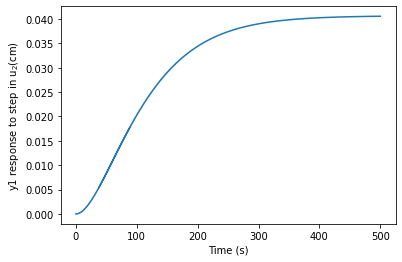

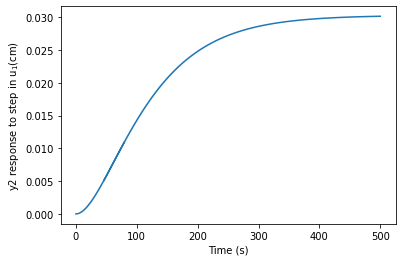

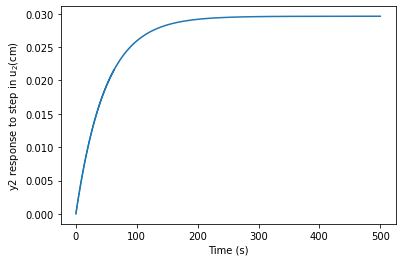

In [ ]:
# Actual step responses
# Plant model(i) or step response

# Generate step response coefficient(ii)
Phi = expm(np.multiply(A,delta_t))
Gamma = multi_dot([Phi-np.eye(4),np.linalg.inv(A),B])

sysd = (Phi, Gamma, C, D, delta_t)

#Step response
t_step, y_step = dstep(sysd, n=N+1) # This will give a (2x51x2) shape tuple

#To convert the tuple into an array
y_step_ar = np.asarray(y_step) 

y1_u1 = y_step_ar[0][:,0]
y2_u1 = y_step_ar[0][:,1]
y1_u2 = y_step_ar[1][:,0]
y2_u2 = y_step_ar[1][:,1]

#Plotting all the step responses (4 in total)
plt.figure()
plt.step(t_step, y1_u1)
plt.xlabel('Time (s)')
plt.ylabel('y1 response to step in u$_1$(cm)');

plt.figure()
plt.step(t_step, y1_u2)
plt.xlabel('Time (s)')
plt.ylabel('y1 response to step in u$_2$(cm)');

plt.figure()
plt.step(t_step, y2_u1)
plt.xlabel('Time (s)')
plt.ylabel('y2 response to step in u$_1$(cm)');

plt.figure()
plt.step(t_step, y2_u2)
plt.xlabel('Time (s)')
plt.ylabel('y2 response to step in u$_2$(cm)');
Gamma

In [ ]:
y1_final = np.zeros((round(t_f/delta_t)+1, 1))
y2_final = np.zeros((round(t_f/delta_t)+1, 1))
u1_final = np.zeros((round(t_f/delta_t)+1, 1))
u2_final = np.zeros((round(t_f/delta_t)+1, 1))

In [ ]:
# Dynamic matrix
# sf (Just for check and simpify the sf code)
Sf11 = np.zeros((P,M)) # initialization
Sf12 = np.zeros((P,M)) # initialization
Sf21 = np.zeros((P,M)) # initialization
Sf22 = np.zeros((P,M)) # initialization
for i in range(0,M):
  Sf11[i:,i] = y1_u1[1:P+1-i]
for i in range(0,M):
  Sf12[i:,i] = y1_u2[1:P+1-i]
for i in range(0,M):
  Sf21[i:,i] = y2_u1[1:P+1-i]
for i in range(0,M):
  Sf22[i:,i] = y2_u2[1:P+1-i]
Sf1 = np.column_stack((Sf11, Sf12))
Sf2 = np.column_stack((Sf21, Sf22))
Sf = np.vstack((Sf1, Sf2))
print(Sf11.shape)
print(Sf12.shape)
print(Sf1.shape)
print(Sf.shape)

# Spast (Just for check and simpify the Spast code)
Spast11 = np.zeros((P,N-2)) # initialization
Spast12 = np.zeros((P,N-2)) # initialization
Spast21 = np.zeros((P,N-2)) # initialization
Spast22 = np.zeros((P,N-2)) # initialization
for i in range(0,P):
  Spast11[i,0:N-2-i] = y1_u1[2+i:N]
for i in range(0,P):
  Spast12[i,0:N-2-i] = y1_u2[2+i:N]
for i in range(0,P):
  Spast21[i,0:N-2-i] = y2_u1[2+i:N]
for i in range(0,P):
  Spast22[i,0:N-2-i] = y2_u2[2+i:N]
Spast1 = np.column_stack((Spast11, Spast21))
Spast2 = np.column_stack((Spast12, Spast22))
Spast = np.vstack((Spast1,Spast2))
print(Spast11.shape)


# SN
SN11 = y1_u1[N]
SN12 = y1_u2[N]
SN21 = y2_u1[N]
SN22 = y2_u2[N]

(6, 5)
(6, 5)
(6, 10)
(12, 10)
(6, 4998)


In [ ]:
# Initialize variables - generalize for the loop
u1 = np.ones((1,round(t_f/delta_t)+1)) * qa # initialize input vector
u2 = np.ones((1,round(t_f/delta_t)+1)) * qb # initialize input vector
x1 = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize state vector
x2 = np.ones((1,round(t_f/delta_t)+1)) * h2_0 # initialize state vector
x3 = np.ones((1,round(t_f/delta_t)+1)) * h3_0 # initialize state vector
x4 = np.ones((1,round(t_f/delta_t)+1)) * h4_0 # initialize state vector
x = np.vstack((x1,x2,x3,x4))
y1 = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize output vector
y2 = np.ones((1,round(t_f/delta_t)+1)) * h2_0 # initialize output vector

u1_past = np.ones(N-1) * qa  # initialize past inputs for DMC calculation
u2_past = np.ones(N-1) * qb  # initialize past inputs for DMC calculation

d_hat1 = np.zeros((P,round(t_f/delta_t)+1)) # initialize predicted disturbances
d_hat2 = np.zeros((P,round(t_f/delta_t)+1)) 
y1_hat = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize output vector
y2_hat = np.ones((1,round(t_f/delta_t)+1)) * h2_0 
error1 = np.zeros((1,round(t_f/delta_t)+1)) # initialize error
error2 = np.zeros((1,round(t_f/delta_t)+1))

In [ ]:
u1

array([[175.7, 175.7, 175.7, ..., 175.7, 175.7, 175.7]])

In [ ]:
u2

array([[19.53, 19.53, 19.53, ..., 19.53, 19.53, 19.53]])

In [ ]:
for k in range(0,round(t_f/delta_t),1):
  delta_u1_past = u1_past[0:N-2] - u1_past[1:N-1]
  delta_u2_past = u2_past[0:N-2] - u2_past[1:N-1]
  delta_u_past = np.hstack((delta_u1_past,delta_u2_past)).reshape(2*(N-2),1)

  u1_past_flip = np.flip(u1_past)
  u2_past_flip = np.flip(u2_past)
  u1_p = u1_past_flip[0:P].reshape(P,1) 
  u2_p = u2_past_flip[0:P].reshape(P,1) 

  E1 = r1-((Spast1@delta_u_past).reshape(P,1)+SN11*u1_p+SN12*u2_p+d_hat1[:,k].reshape(P,1))
  E2 = r2-((Spast2@delta_u_past).reshape(P,1)+SN21*u1_p+SN22*u2_p+d_hat2[:,k].reshape(P,1))

  delta_u1_f = np.linalg.inv((Sf1.T@Sf1)+W)@Sf1.T@E1
  delta_u2_f = np.linalg.inv((Sf2.T@Sf2)+W)@Sf2.T@E2


  if (k>0):
   u1[0,k] = delta_u1_f[0] + u1[0,k-1]
   u1[0,k+1] = u1[0,k]
  else:
    u1[0,k] = qa
  
  if (k>0):
   u2[0,k] = delta_u2_f[0] + u2[0,k-1]
   u2[0,k+1] = u2[0,k]
  else:
    u2[0,k] = qb
  u = np.vstack((u1,u2))

  # Plant equations
  x[:,k+1] = np.dot(Phi,x[:,k])+np.dot(Gamma,u[:,k])
  D1 = D[0,:].reshape(1,2)
  D2 = D[1,:].reshape(1,2)
  C1 = C[0,:].reshape(1,4)
  C2 = C[1,:].reshape(1,4)
  y1[:,k+1] = np.dot(C1,x[:,k+1])+np.dot(D1,u[:,k+1])
  y2[:,k+1] = np.dot(C2,x[:,k+1])+np.dot(D2,u[:,k+1])

  #Step response model prediction for k+1
  y1_hat[:,k+1] = np.dot(Sf11[0,:],delta_u1_f[0:M])+np.dot(Sf12[0,:],delta_u2_f[0:M])+np.dot(Spast11[0,:],delta_u1_past)+np.dot(Spast12[0,:],delta_u2_past)+SN11*u1_p[0]+SN12*u2_p[0]
  y2_hat[:,k+1] = np.dot(Sf21[0,:],delta_u1_f[0:M])+np.dot(Sf22[0,:],delta_u2_f[0:M])+np.dot(Spast21[0,:],delta_u1_past)+np.dot(Spast22[0,:],delta_u2_past)+SN21*u1_p[0]+SN22*u2_p[0]

  #Calculation of disturbance correction
  d_hat1[:,k+1] = y1[0,k+1]-y1_hat[:,k+1]
  d_hat2[:,k+1] = y2[0,k+1]-y2_hat[:,k+1]

  u1_past = np.hstack((u1[0,k],u1_past[0:N-2]))
  u2_past = np.hstack((u2[0,k],u2_past[0:N-2]))

  error1[:,k+1] = r1[1,0]-y1[0,k+1]
  error2[:,k+1] = r2[1,0]-y2[0,k+1] 

In [1]:
MSE1 = np.sum(np.square(error1)) / t_f
MSE2 = np.sum(np.square(error2)) / t_f

plt.figure()
plt.plot(t,y1[0],label='output')
plt.plot(t,np.ones(len(t))*18, '--', label = 'Set Point')
plt.xlabel('time [s]')
plt.legend()
plt.ylabel('The height in first tank (cm)') 
plt.ylim(0,30)

plt.figure()
plt.plot(t,y2[0],label='output')
plt.plot(t,np.ones(len(t))*15, '--', label = 'Set Point')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('The height in second tank (cm)') 
plt.ylim(0,30)

plt.figure()
plt.plot(t,u1[0],label='input')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Volumetric flow rate in first pump, (cm^3/s)') 
# plt.ylim(0,800)

plt.figure()
plt.plot(t,u2[0],label='input')
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('Volumetric flow rate in second pump, (cm^3/s)');
plt.ylim(15,25)


NameError: ignored

In [ ]:
u2

array([[19.53      , 19.53001333, 19.5300266 , ..., 20.43708751,
        20.43709244, 20.43709244]])

In [ ]:
print(y1[0][-1])
print(y2[0][-1])

17.984325364169386
13.618702206951536


In [ ]:
MSE1 

81.3231670698581

In [ ]:
MSE2 

103.08573519234535

In [ ]:
u1

array([[175.7       , 175.70587533, 175.71172183, ..., 429.65768306,
        429.65770763, 429.65770763]])

In [ ]:
u2

array([[19.53      , 19.53001333, 19.5300266 , ..., 20.43708751,
        20.43709244, 20.43709244]])